## Load required Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import ast
import warnings
warnings.filterwarnings('ignore')

## Load Datasets into Dataframes

In [3]:
matches_df = pd.read_csv(r'D:\Masters\Spring 2024\MATH 448\Project\Datasets\IPL_Matches_2008_2022.csv')
ball_by_ball_df = pd.read_csv(r'D:\Masters\Spring 2024\MATH 448\Project\Datasets\IPL_Ball_by_Ball_2008_2022.csv')
international_players_df = pd.read_csv(r'D:\Masters\Spring 2024\MATH 448\Project\Datasets\Players_SuperCleaned.csv')
ipl_auction_data=pd.read_csv(r'D:\Masters\Spring 2024\MATH 448\Project\Datasets\IPLPlayerAuctionData.csv')

## Define Functions 

In [4]:
def match_outcome(row):
    if row['WinningTeam'] == row['Team1']:
        return 'Win'
    elif row['WinningTeam'] == row['Team2']:
        return 'Loss'
    else:
        return 'No Result'

## Missing Values Handling & EDA

In [5]:
print(matches_df.head())
print(matches_df.info())
print(matches_df.describe())

        ID       City        Date Season  MatchNumber  \
0  1312200  Ahmedabad  2022-05-29   2022        Final   
1  1312199  Ahmedabad  2022-05-27   2022  Qualifier 2   
2  1312198    Kolkata  2022-05-25   2022   Eliminator   
3  1312197    Kolkata  2022-05-24   2022  Qualifier 1   
4  1304116     Mumbai  2022-05-22   2022           70   

                         Team1                 Team2  \
0             Rajasthan Royals        Gujarat Titans   
1  Royal Challengers Bangalore      Rajasthan Royals   
2  Royal Challengers Bangalore  Lucknow Super Giants   
3             Rajasthan Royals        Gujarat Titans   
4          Sunrisers Hyderabad          Punjab Kings   

                              Venue            TossWinner TossDecision  \
0  Narendra Modi Stadium, Ahmedabad      Rajasthan Royals          bat   
1  Narendra Modi Stadium, Ahmedabad      Rajasthan Royals        field   
2             Eden Gardens, Kolkata  Lucknow Super Giants        field   
3             Eden Garde

In [6]:

# Check for missing values in the matches dataset
#Data Imputation for city
venue_to_city = {
    'Dubai International Cricket Stadium': 'UAE',
    'Sharjah Cricket Stadium': 'UAE'
}
# Apply mapping for rows where City is NaN and Venue is known
matches_df['City'] = matches_df.apply(
    lambda row: venue_to_city[row['Venue']] if pd.isnull(row['City']) and row['Venue'] in venue_to_city else row['City'],
    axis=1
)
# Update 'WinningTeam', 'SuperOver', and 'Player_of_Match' columns where values are NA to 'No Result'
matches_df['WinningTeam'].fillna('No Result', inplace=True)
matches_df['Player_of_Match'].fillna('No Result', inplace=True)

# Convert string representations of lists into actual lists if necessary
matches_df['Team1Players'] = matches_df['Team1Players'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
matches_df['Team2Players'] = matches_df['Team2Players'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# You can verify the updates by checking for missing values again or inspecting the updated columns.
print(matches_df[['City','WinningTeam','Player_of_Match']].isnull().sum())


City               0
WinningTeam        0
Player_of_Match    0
dtype: int64


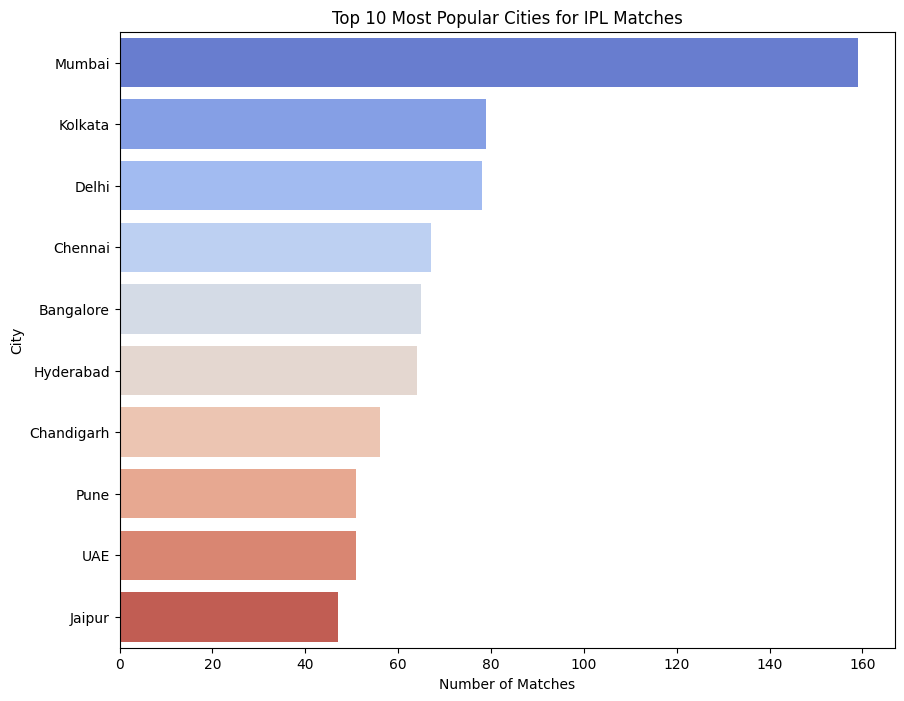

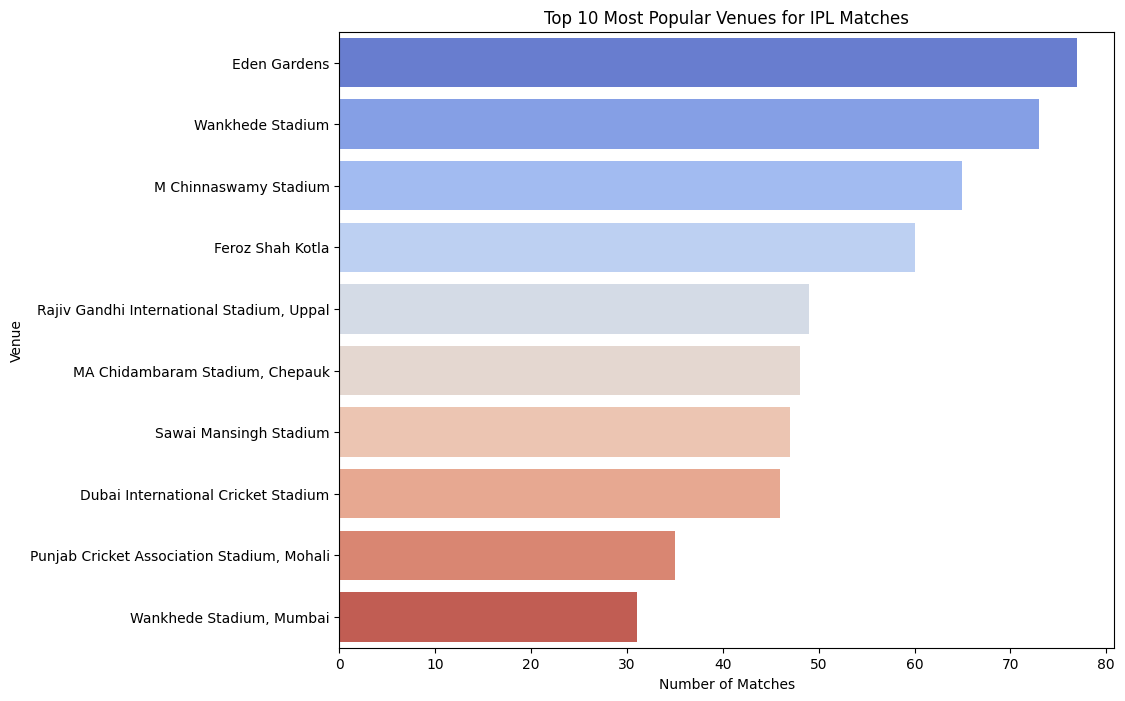

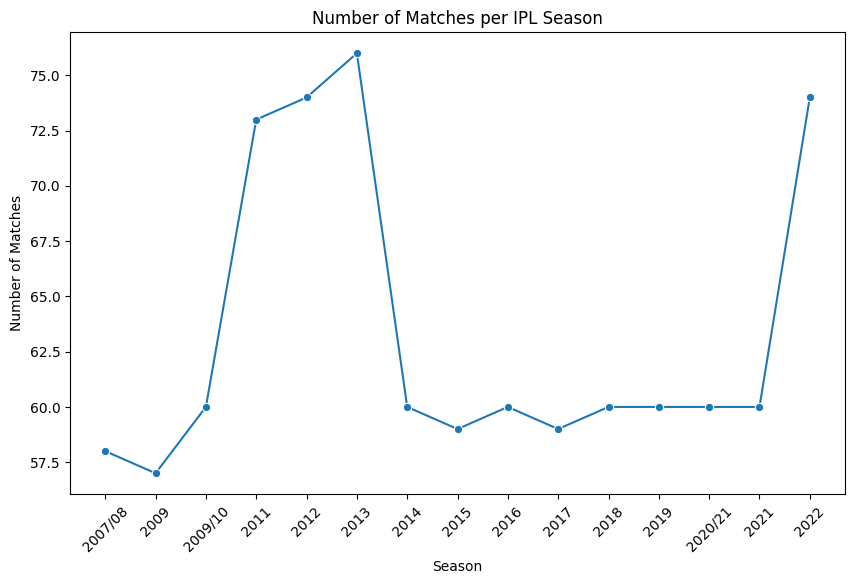

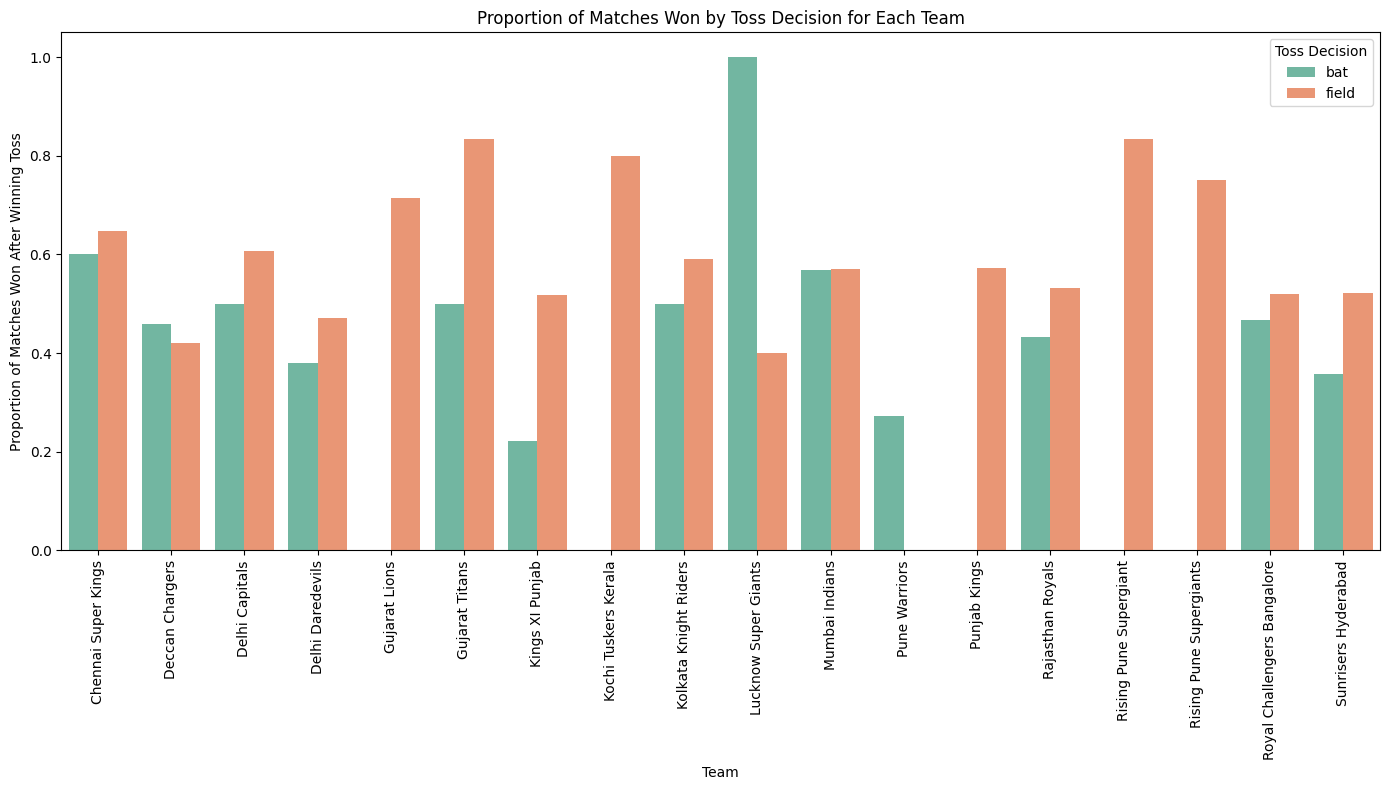

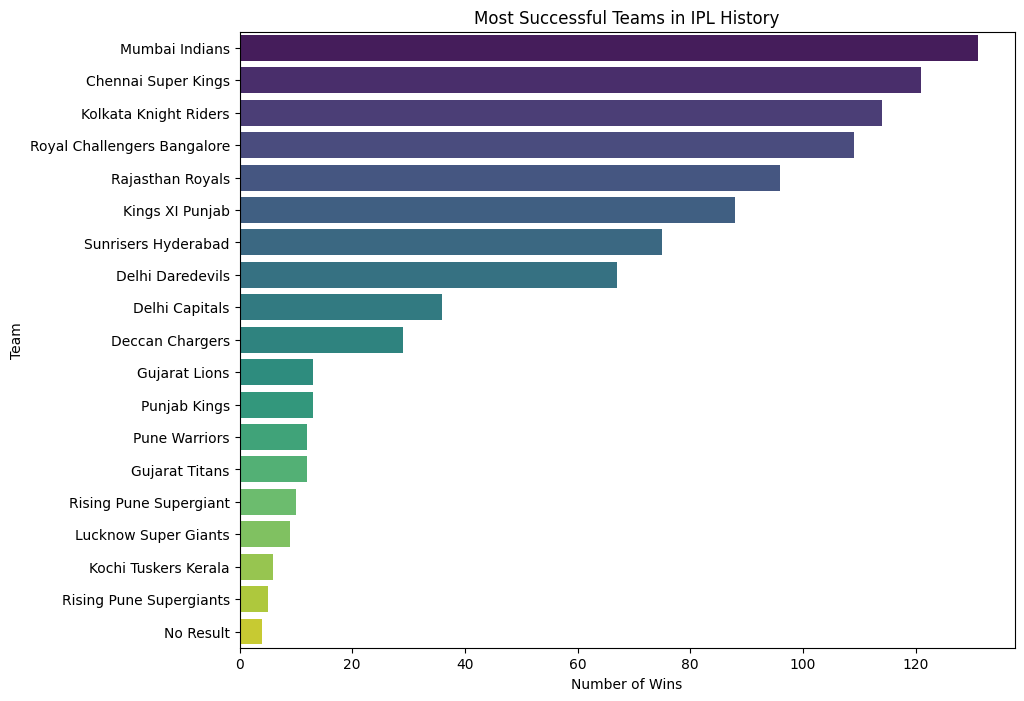

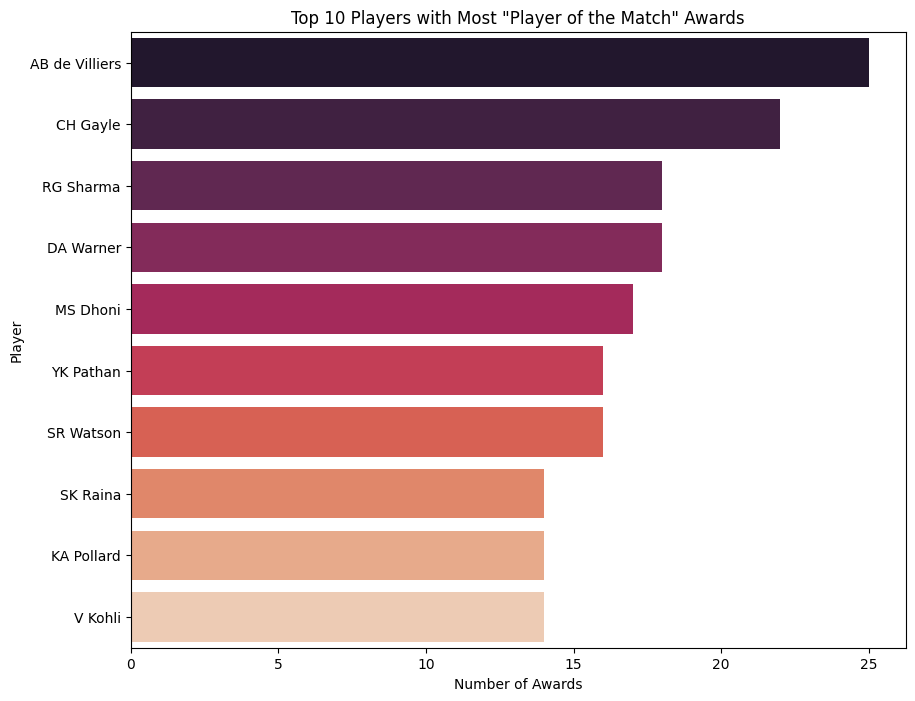

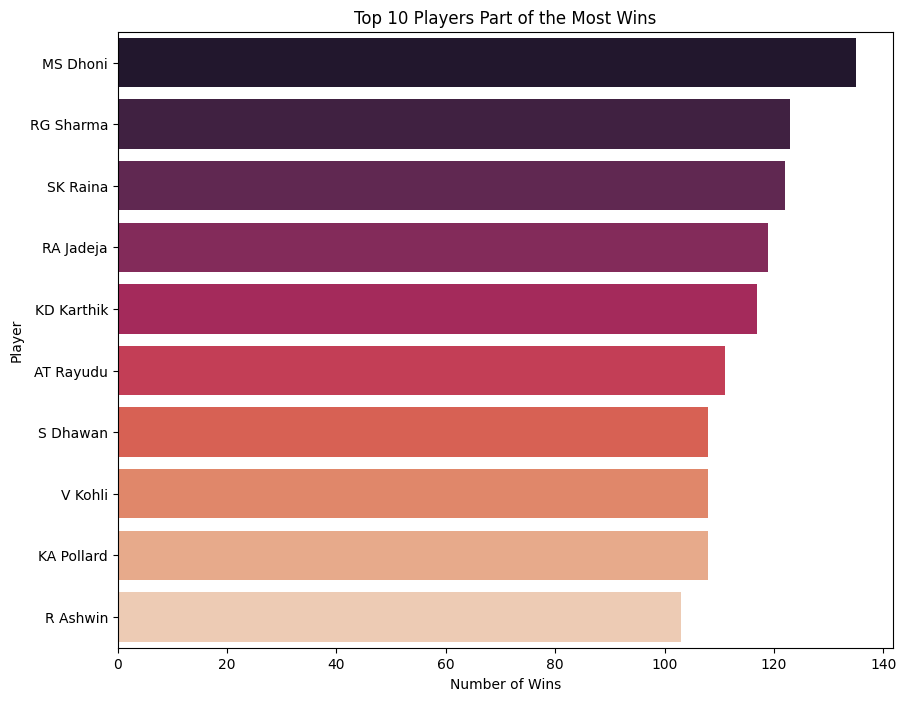

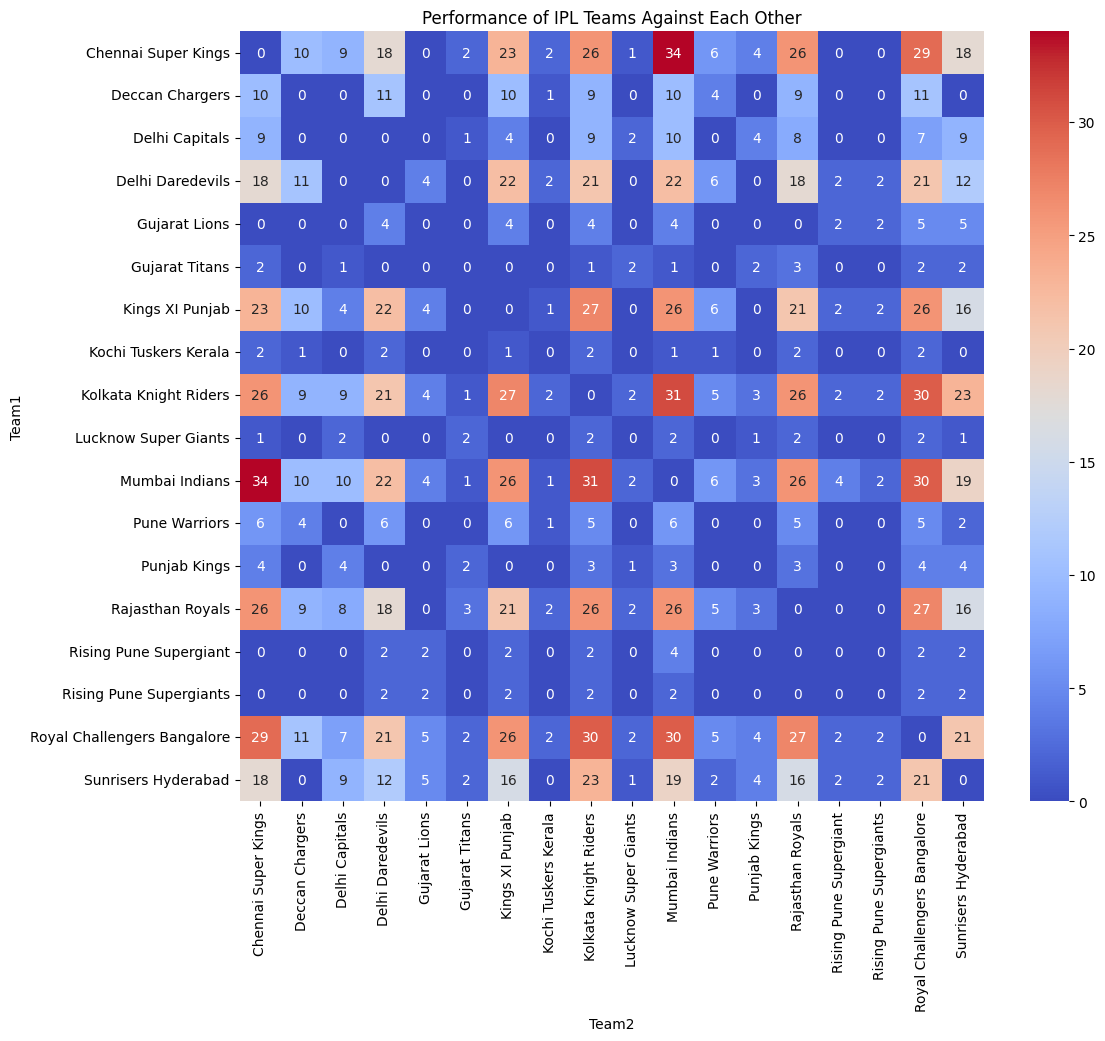

In [7]:
matches_eda_df = matches_df[['Season', 'City', 'MatchNumber', 'Team1', 'Team2', 'Venue', 'TossWinner', 'TossDecision', 'WinningTeam', 'Player_of_Match','Team1Players','Team2Players']]

# City & Venue
most_popular_cities = matches_eda_df['City'].value_counts().head(10)
most_popular_venues = matches_eda_df['Venue'].value_counts().head(10)

plt.figure(figsize=(10, 8))
sns.barplot(y=most_popular_cities.index, x=most_popular_cities.values, palette='coolwarm')
plt.title('Top 10 Most Popular Cities for IPL Matches')
plt.xlabel('Number of Matches')
plt.ylabel('City')
plt.show()

plt.figure(figsize=(10, 8))
sns.barplot(y=most_popular_venues.index, x=most_popular_venues.values, palette='coolwarm')
plt.title('Top 10 Most Popular Venues for IPL Matches')
plt.xlabel('Number of Matches')
plt.ylabel('Venue')
plt.show()

# Season & Match Number
matches_per_season = matches_eda_df['Season'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x=matches_per_season.index, y=matches_per_season.values, marker='o')
plt.title('Number of Matches per IPL Season')
plt.xlabel('Season')
plt.ylabel('Number of Matches')
plt.xticks(rotation=45)
plt.show()

# Toss (Tosswinner & TossDecision)
matches_eda_df['TossWinnerWonMatch'] = matches_eda_df.apply(
    lambda row: 'Won' if row['TossWinner'] == row['WinningTeam'] else 'Lost', axis=1)


# Assuming matches_eda_df is already prepared with the 'TossWinnerWonMatch' column

# Group the data by 'TossWinner', 'TossDecision', and 'TossWinnerWonMatch', then count
toss_impact_team = matches_eda_df.groupby(['TossWinner', 'TossDecision', 'TossWinnerWonMatch']).size().reset_index(name='Counts')

# Calculate total counts for each 'TossWinner' + 'TossDecision' combination to normalize the counts
team_decision_totals = toss_impact_team.groupby(['TossWinner', 'TossDecision'])['Counts'].transform('sum')
toss_impact_team['Proportion'] = toss_impact_team['Counts'] / team_decision_totals

# Filter out to show only proportions of matches won
toss_impact_team_win = toss_impact_team[toss_impact_team['TossWinnerWonMatch'] == 'Won']

# Create a bar plot showing the impact of toss decisions for each team
plt.figure(figsize=(14, 8))
sns.barplot(x='TossWinner', y='Proportion', hue='TossDecision', data=toss_impact_team_win, palette='Set2')
plt.xticks(rotation=90)
plt.title('Proportion of Matches Won by Toss Decision for Each Team')
plt.xlabel('Team')
plt.ylabel('Proportion of Matches Won After Winning Toss')
plt.legend(title='Toss Decision')
plt.tight_layout()
plt.show()


# WinningTeam
win_counts = matches_eda_df['WinningTeam'].value_counts()
plt.figure(figsize=(10, 8))
sns.barplot(y=win_counts.index, x=win_counts.values, palette='viridis')
plt.title('Most Successful Teams in IPL History')
plt.xlabel('Number of Wins')
plt.ylabel('Team')
plt.show()

# Player of the Match
top_players = matches_eda_df['Player_of_Match'].value_counts().head(10)
plt.figure(figsize=(10, 8))
sns.barplot(x=top_players.values, y=top_players.index, palette='rocket')
plt.title('Top 10 Players with Most "Player of the Match" Awards')
plt.xlabel('Number of Awards')
plt.ylabel('Player')
plt.show()


# Initialize a dictionary to count wins for each player
player_win_counts = {}

# Iterate through each match in the dataframe
for index, row in matches_eda_df.iterrows():
    # Combine both teams' players into one list
    all_players = row['Team1Players'] + row['Team2Players']
    # Get the set of unique players in the match
    unique_players = set(all_players)
    # Determine the winning team's players
    winning_players = row['Team1Players'] if row['WinningTeam'] == row['Team1'] else row['Team2Players']
    # Update the win count for each player in the winning team
    for player in winning_players:
        if player in unique_players:  # This check is to prevent counting a player twice if they got traded mid-season
            player_win_counts[player] = player_win_counts.get(player, 0) + 1

# Convert the win counts to a DataFrame
player_wins_df = pd.DataFrame(list(player_win_counts.items()), columns=['Player', 'WinCount'])

# Sort the players by the number of wins
player_wins_df = player_wins_df.sort_values(by='WinCount', ascending=False)

# Visualize the top players part of the most wins
plt.figure(figsize=(10, 8))
top_players_wins = player_wins_df.head(10)
sns.barplot(x='WinCount', y='Player', data=top_players_wins, palette='rocket')
plt.title('Top 10 Players Part of the Most Wins')
plt.xlabel('Number of Wins')
plt.ylabel('Player')
plt.show()


# Apply the function to the DataFrame
matches_df['Team1_Outcome'] = matches_df.apply(match_outcome, axis=1)

# Create a pivot table to aggregate match outcomes between Team1 and Team2
team_performance_matrix = pd.pivot_table(matches_df, values='MatchNumber', 
                                         index='Team1', columns='Team2', 
                                         aggfunc=lambda x: len(x), fill_value=0)

# Since the matrix only shows matches where a team was Team1, we need to account for when they were Team2
# We'll add the transpose of the matrix to itself since it's symmetric (Team1 vs Team2 is the same as Team2 vs Team1)
team_performance_matrix += team_performance_matrix.T

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(team_performance_matrix, annot=True, cmap='coolwarm', fmt='d')
plt.title('Performance of IPL Teams Against Each Other')
plt.xlabel('Team2')
plt.ylabel('Team1')
plt.show()


In [8]:
ball_by_ball_df['overs']==ball_by_ball_df['overs']+1
ball_by_ball_df.rename(columns={'kind': 'TypeOfDismissal'}, inplace=True)

print(ball_by_ball_df.head())
print(ball_by_ball_df.info())
print(ball_by_ball_df.describe())

        ID  innings  overs  ballnumber       batter          bowler  \
0  1312200        1      0           1  YBK Jaiswal  Mohammed Shami   
1  1312200        1      0           2  YBK Jaiswal  Mohammed Shami   
2  1312200        1      0           3   JC Buttler  Mohammed Shami   
3  1312200        1      0           4  YBK Jaiswal  Mohammed Shami   
4  1312200        1      0           5  YBK Jaiswal  Mohammed Shami   

   non-striker extra_type  batsman_run  extras_run  total_run  non_boundary  \
0   JC Buttler        NaN            0           0          0             0   
1   JC Buttler    legbyes            0           1          1             0   
2  YBK Jaiswal        NaN            1           0          1             0   
3   JC Buttler        NaN            0           0          0             0   
4   JC Buttler        NaN            0           0          0             0   

   isWicketDelivery player_out TypeOfDismissal fielders_involved  \
0                 0        NaN

In [9]:
ball_by_ball_eda_df = ball_by_ball_df[['ID','innings','overs', 'ballnumber', 'batter', 'bowler', 'total_run', 'non_boundary', 'isWicketDelivery', 'TypeOfDismissal','BattingTeam']]
ball_by_ball_eda_df.head()

,ID,innings,overs,ballnumber,batter,bowler,total_run,non_boundary,isWicketDelivery,TypeOfDismissal,BattingTeam
0,1312200,1,0,1,YBK Jaiswal,Mohammed Shami,0,0,0,NaN,Rajasthan Royals
1,1312200,1,0,2,YBK Jaiswal,Mohammed Shami,1,0,0,NaN,Rajasthan Royals
2,1312200,1,0,3,JC Buttler,Mohammed Shami,1,0,0,NaN,Rajasthan Royals
3,1312200,1,0,4,YBK Jaiswal,Mohammed Shami,0,0,0,NaN,Rajasthan Royals
4,1312200,1,0,5,YBK Jaiswal,Mohammed Shami,0,0,0,NaN,Rajasthan Royals


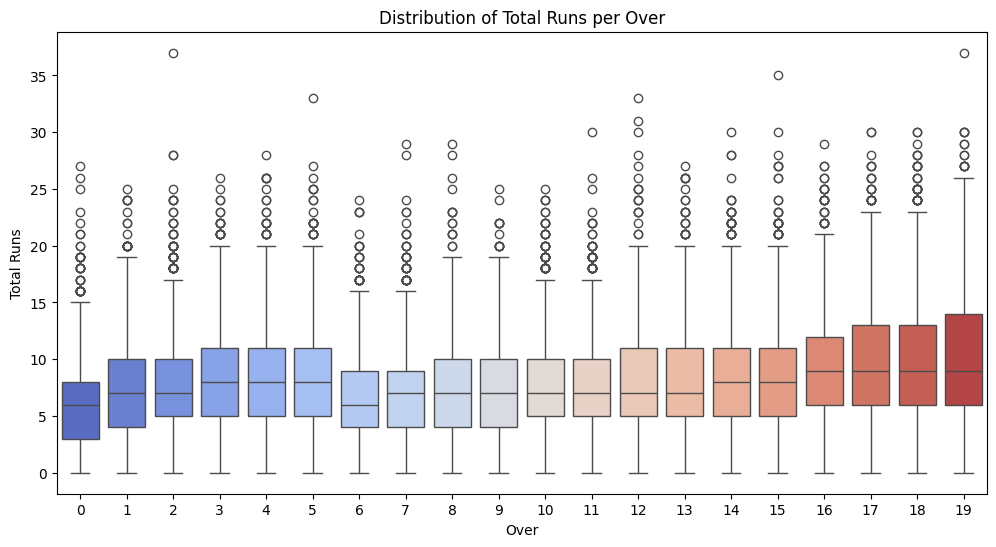

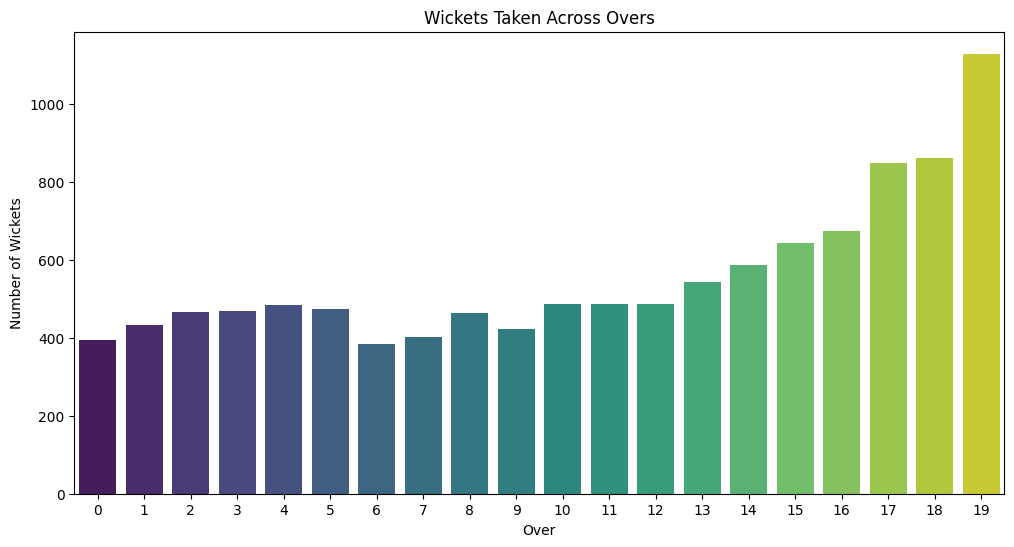

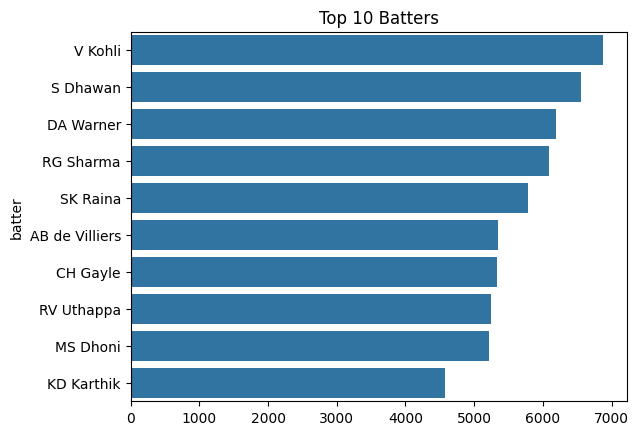

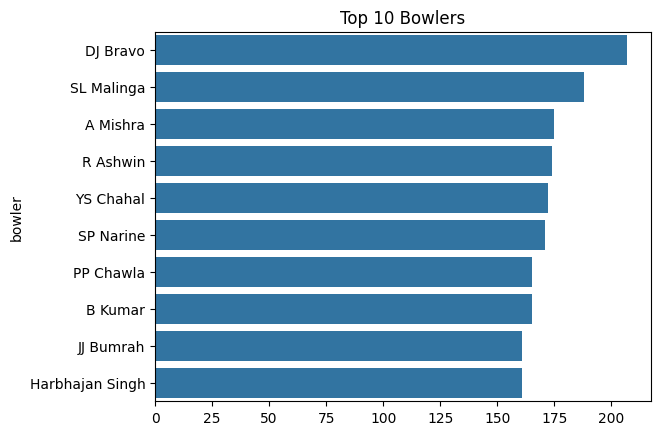

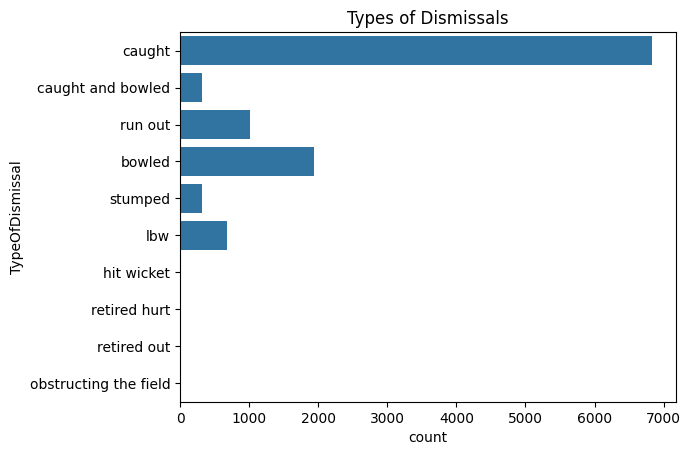

In [10]:
runs_per_over = ball_by_ball_eda_df.groupby(['ID','innings', 'overs'])['total_run'].sum().reset_index()

# Step 2: Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='overs', y='total_run', data=runs_per_over, palette="coolwarm")
plt.title('Distribution of Total Runs per Over')
plt.xlabel('Over')
plt.ylabel('Total Runs')
plt.show()

# Assuming 'over' is correctly represented in your dataframe
wickets_df = ball_by_ball_eda_df[ball_by_ball_eda_df['isWicketDelivery'] == 1]

plt.figure(figsize=(12, 6))
sns.countplot(x='overs', data=wickets_df, palette='viridis')
plt.title('Wickets Taken Across Overs')
plt.xlabel('Over')
plt.ylabel('Number of Wickets')
plt.show()

top_batters = ball_by_ball_eda_df.groupby('batter')['total_run'].sum().sort_values(ascending=False).head(10)
top_bowlers = ball_by_ball_eda_df[ball_by_ball_eda_df['isWicketDelivery'] == 1].groupby('bowler')['isWicketDelivery'].count().sort_values(ascending=False).head(10)

sns.barplot(x=top_batters.values, y=top_batters.index)
plt.title('Top 10 Batters')
plt.show()

sns.barplot(x=top_bowlers.values, y=top_bowlers.index)
plt.title('Top 10 Bowlers')
plt.show()

sns.countplot(y='TypeOfDismissal', data=ball_by_ball_eda_df)
plt.title('Types of Dismissals')
plt.show()


## Data Preparation for Model Building

In [11]:
# Create ISTeam1 winner feature
print(matches_df['WinningTeam'].str.strip().unique())
print(matches_df['Team1'].str.strip().unique())

# Update the DataFrame to remove any leading/trailing spaces if found
matches_df['WinningTeam'] = matches_df['WinningTeam'].str.strip()
matches_df['Team1'] = matches_df['Team1'].str.strip()

# Recreate the Target after stripping spaces
matches_df['IsTeam1Winner'] = (matches_df['WinningTeam'] == matches_df['Team1']).astype(int)
print(matches_df['IsTeam1Winner'].unique())


['Gujarat Titans' 'Rajasthan Royals' 'Royal Challengers Bangalore'
 'Punjab Kings' 'Mumbai Indians' 'Lucknow Super Giants'
 'Sunrisers Hyderabad' 'Delhi Capitals' 'Kolkata Knight Riders'
 'Chennai Super Kings' 'Kings XI Punjab' 'No Result' 'Delhi Daredevils'
 'Rising Pune Supergiant' 'Gujarat Lions' 'Rising Pune Supergiants'
 'Pune Warriors' 'Deccan Chargers' 'Kochi Tuskers Kerala']
['Rajasthan Royals' 'Royal Challengers Bangalore' 'Sunrisers Hyderabad'
 'Delhi Capitals' 'Chennai Super Kings' 'Gujarat Titans'
 'Lucknow Super Giants' 'Kolkata Knight Riders' 'Punjab Kings'
 'Mumbai Indians' 'Kings XI Punjab' 'Delhi Daredevils'
 'Rising Pune Supergiant' 'Gujarat Lions' 'Rising Pune Supergiants'
 'Pune Warriors' 'Deccan Chargers' 'Kochi Tuskers Kerala']
[0 1]


In [12]:
# create head-to-head win ratios feature
def calculate_head_to_head(df):
    # Create a match pair identifier and sort teams to ensure consistent pairing
    df['match_pair'] = df.apply(lambda x: '_'.join(sorted([x['Team1'], x['Team2']])), axis=1)
    head_to_head_record = {}
    
    # Iterate through each match, sorted by date to maintain chronological order
    for index, row in df.sort_values('Date').iterrows():
        pair = row['match_pair']
        if pair not in head_to_head_record:
            head_to_head_record[pair] = {'total_matches': 0, 'wins': {}}
        
        # Ensure both teams have entries in the dictionary
        teams = pair.split('_')
        if teams[0] not in head_to_head_record[pair]['wins']:
            head_to_head_record[pair]['wins'][teams[0]] = 0
        if teams[1] not in head_to_head_record[pair]['wins']:
            head_to_head_record[pair]['wins'][teams[1]] = 0
        
        # Increment total matches count
        head_to_head_record[pair]['total_matches'] += 1
        
        # Increment win count for the winning team
        if row['WinningTeam'] in teams:
            head_to_head_record[pair]['wins'][row['WinningTeam']] += 1
        
        # Assign win ratios to Team1 and Team2 based on the current match teams
        team1_ratio = head_to_head_record[pair]['wins'].get(row['Team1'], 0) / head_to_head_record[pair]['total_matches']
        team2_ratio = head_to_head_record[pair]['wins'].get(row['Team2'], 0) / head_to_head_record[pair]['total_matches']
        
        # Store the win ratio for the current Team1 in the DataFrame
        df.loc[index, 'Team1HeadToHeadWinRatio'] = team1_ratio
        df.loc[index, 'Team2HeadToHeadWinRatio'] = team2_ratio
    
    return df

# Apply the function to your DataFrame
matches_df = calculate_head_to_head(matches_df.copy())

In [13]:
# create features based on international statistics dataset
t20_columns = ['NAME', 'BATTING_T20s_Mat', 'BATTING_T20s_Runs', 'BOWLING_T20s_Wkts', 'BATTING_T20s_Ave', 'BOWLING_T20s_Econ']
players_df = international_players_df[t20_columns]

# Function to aggregate player stats for a team
def aggregate_player_stats(team_players, players_data):
    filtered_data = players_data[players_data['NAME'].isin(team_players)]
    if not filtered_data.empty:
        return {
            'avg_t20_matches': filtered_data['BATTING_T20s_Mat'].mean(),
            'total_t20_runs': filtered_data['BATTING_T20s_Runs'].sum(),
            'total_t20_wickets': filtered_data['BOWLING_T20s_Wkts'].sum(),
            'avg_t20_batting_avg': filtered_data['BATTING_T20s_Ave'].mean(),
            'avg_t20_bowling_econ': filtered_data['BOWLING_T20s_Econ'].mean()
        }
    else:
        return {
            'avg_t20_matches': 0,
            'total_t20_runs': 0,
            'total_t20_wickets': 0,
            'avg_t20_batting_avg': 0,
            'avg_t20_bowling_econ': 0
        }

# Create individual columns from the dictionary returned by aggregate_player_stats
for key in ['avg_t20_matches', 'total_t20_runs', 'total_t20_wickets', 'avg_t20_batting_avg', 'avg_t20_bowling_econ']:
    matches_df[f'Team1_{key}'] = matches_df['Team1Players'].apply(lambda x: aggregate_player_stats(x, players_df).get(key))
    matches_df[f'Team2_{key}'] = matches_df['Team2Players'].apply(lambda x: aggregate_player_stats(x, players_df).get(key))



In [14]:
#create feature for number of key batters and players

# Calculate total runs scored by each batter
player_runs = ball_by_ball_df.groupby('batter').agg(total_runs=('total_run', 'sum')).reset_index()

# Make sure to apply the lambda function row-wise using 'axis=1'
ball_by_ball_df['isWicket'] = ball_by_ball_df.apply(
    lambda row: 1 if row['isWicketDelivery'] == 1 and pd.notna(row['TypeOfDismissal']) else 0, 
    axis=1
)
player_wickets = ball_by_ball_df.groupby('bowler').agg(total_wickets=('isWicket', 'sum')).reset_index()

# Define top player thresholds (for example, the top 10% of performers)
top_run_threshold = player_runs['total_runs'].quantile(0.75)
top_wicket_threshold = player_wickets['total_wickets'].quantile(0.75)

# Identify key players
key_batters = player_runs[player_runs['total_runs'] >= top_run_threshold]['batter'].tolist()
key_bowlers = player_wickets[player_wickets['total_wickets'] >= top_wicket_threshold]['bowler'].tolist()

# Function to count key players in each team
def count_key_players(players, key_players):
    return sum([1 for player in players if player in key_players])

# Apply the function to count key batters and bowlers in each match for each team
matches_df['Team1KeyBatters'] = matches_df['Team1Players'].apply(lambda x: count_key_players(x, key_batters))
matches_df['Team2KeyBatters'] = matches_df['Team2Players'].apply(lambda x: count_key_players(x, key_batters))
matches_df['Team1KeyBowlers'] = matches_df['Team1Players'].apply(lambda x: count_key_players(x, key_bowlers))
matches_df['Team2KeyBowlers'] = matches_df['Team2Players'].apply(lambda x: count_key_players(x, key_bowlers))

In [15]:
# Calculate the number of wins for Team1 at each venue
venue_wins = matches_df.groupby(['Venue', 'Team1']).apply(
    lambda x: (x['WinningTeam'] == x['Team1']).sum()
).reset_index(name='Wins')

# Calculate the total games played by Team1 at each venue
venue_games = matches_df.groupby(['Venue', 'Team1']).size().reset_index(name='Games')

# Merge wins and games to calculate the win rate
venue_performance = pd.merge(venue_wins, venue_games, on=['Venue', 'Team1'])
venue_performance['WinRate'] = venue_performance['Wins'] / venue_performance['Games']

# Merge this back into the original DataFrame
matches_df = pd.merge(matches_df, venue_performance[['Venue', 'Team1', 'WinRate']], on=['Venue', 'Team1'], how='left')

# Fill NaN values with zero where no previous games have been played
matches_df['WinRate'] = matches_df['WinRate'].fillna(0)

# Now, matches_df has an additional feature 'WinRate' representing Team1's performance at that venue.
print(matches_df[['Venue', 'Team1', 'WinRate']].head())


                              Venue                        Team1   WinRate
0  Narendra Modi Stadium, Ahmedabad             Rajasthan Royals  0.000000
1  Narendra Modi Stadium, Ahmedabad  Royal Challengers Bangalore  0.500000
2             Eden Gardens, Kolkata  Royal Challengers Bangalore  1.000000
3             Eden Gardens, Kolkata             Rajasthan Royals  0.000000
4          Wankhede Stadium, Mumbai          Sunrisers Hyderabad  0.333333


In [16]:
# Display the modified DataFrame
# Export matches_df to an Excel file
matches_df.to_excel(r'D:\Masters\Spring 2024\MATH 448\Project\Outputs\matches_output.xlsx', index=False)

print(matches_df.head())


        ID       City        Date Season  MatchNumber  \
0  1312200  Ahmedabad  2022-05-29   2022        Final   
1  1312199  Ahmedabad  2022-05-27   2022  Qualifier 2   
2  1312198    Kolkata  2022-05-25   2022   Eliminator   
3  1312197    Kolkata  2022-05-24   2022  Qualifier 1   
4  1304116     Mumbai  2022-05-22   2022           70   

                         Team1                 Team2  \
0             Rajasthan Royals        Gujarat Titans   
1  Royal Challengers Bangalore      Rajasthan Royals   
2  Royal Challengers Bangalore  Lucknow Super Giants   
3             Rajasthan Royals        Gujarat Titans   
4          Sunrisers Hyderabad          Punjab Kings   

                              Venue            TossWinner TossDecision  ...  \
0  Narendra Modi Stadium, Ahmedabad      Rajasthan Royals          bat  ...   
1  Narendra Modi Stadium, Ahmedabad      Rajasthan Royals        field  ...   
2             Eden Gardens, Kolkata  Lucknow Super Giants        field  ...   
3   

## Feature Selection

In [17]:
# Encoding categorical features
categorical_features = ['City', 'Venue', 'TossWinner', 'TossDecision']
matches_df = pd.get_dummies(matches_df, columns=categorical_features)

In [18]:
# Assuming 'WinningTeam' is already in your data and you need to set a binary target
# Here we assume you want to predict if 'Team1' wins
# Selecting features for the model: include numeric features and the created dummy variables
features = [
    'Team1KeyBatters', 'Team2KeyBatters', 'Team1KeyBowlers', 'Team2KeyBowlers',
    'Team1HeadToHeadWinRatio', 'Team2HeadToHeadWinRatio',
    'Team1_avg_t20_matches', 'Team2_avg_t20_matches',
    'Team1_total_t20_runs', 'Team2_total_t20_runs',
    'Team1_total_t20_wickets', 'Team2_total_t20_wickets',
    'Team1_avg_t20_batting_avg', 'Team2_avg_t20_batting_avg',
    'Team1_avg_t20_bowling_econ', 'Team2_avg_t20_bowling_econ',
    'WinRate'
] + [col for col in matches_df.columns if col.startswith('City_') or col.startswith('Venue_') or col.startswith('TossWinner_') or col.startswith('TossDecision_') and col != 'Team1_Outcome']

model_df = matches_df[features + ['IsTeam1Winner']]

# Replace all NaN values in model_df with 0
model_df.fillna(0, inplace=True)

print(model_df.head())

   Team1KeyBatters  Team2KeyBatters  Team1KeyBowlers  Team2KeyBowlers  \
0                7                5                4                5   
1                5                7                4                4   
2                5                7                4                4   
3                7                5                4                4   
4                5                4                2                2   

   Team1HeadToHeadWinRatio  Team2HeadToHeadWinRatio  Team1_avg_t20_matches  \
0                 0.000000                 1.000000               0.000000   
1                 0.481481                 0.444444              18.000000   
2                 1.000000                 0.000000              18.000000   
3                 0.000000                 1.000000               0.000000   
4                 0.500000                 0.500000              15.666667   

   Team2_avg_t20_matches  Team1_total_t20_runs  Team2_total_t20_runs  ...  \
0              

## Training and Testing Datasets

In [19]:
# Convert 'Date' to datetime type if not already
matches_df['Date'] = pd.to_datetime(matches_df['Date'])

# Create a column for the year if it doesn't exist
matches_df['Year'] = matches_df['Date'].dt.year

# Split the data based on the year
train_df = model_df[matches_df['Year'] <= 2021]
test_df = model_df[matches_df['Year'] == 2022]

# Prepare feature matrices and target vectors
X_train = train_df.drop('IsTeam1Winner', axis=1)
y_train = train_df['IsTeam1Winner']
X_test = test_df.drop('IsTeam1Winner', axis=1)
y_test = test_df['IsTeam1Winner']

## Model Building

#### Logistic regression

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize and train the logistic regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Predict on the test set
y_pred_logistic = logistic_model.predict(X_test)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic))
print("Classification Report:\n", classification_report(y_test, y_pred_logistic))

Logistic Regression Accuracy: 0.6756756756756757
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.65      0.67        37
           1       0.67      0.70      0.68        37

    accuracy                           0.68        74
   macro avg       0.68      0.68      0.68        74
weighted avg       0.68      0.68      0.68        74



### Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the random forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = random_forest_model.predict(X_test)

# Evaluate the model
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.7837837837837838
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.70      0.76        37
           1       0.74      0.86      0.80        37

    accuracy                           0.78        74
   macro avg       0.79      0.78      0.78        74
weighted avg       0.79      0.78      0.78        74



### SVM Model

In [22]:
from sklearn.svm import SVC

# Initialize and train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.8108108108108109
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.65      0.77        37
           1       0.73      0.97      0.84        37

    accuracy                           0.81        74
   macro avg       0.85      0.81      0.81        74
weighted avg       0.85      0.81      0.81        74



### Gradient Boosting

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train the Gradient Boosting model
gbc_model = GradientBoostingClassifier()
gbc_model.fit(X_train, y_train)

# Predict on the test set
y_pred_gbc = gbc_model.predict(X_test)

# Evaluate the model
print("Gradient Boosting Classifier Accuracy:", accuracy_score(y_test, y_pred_gbc))
print("Classification Report:\n", classification_report(y_test, y_pred_gbc))


Gradient Boosting Classifier Accuracy: 0.8378378378378378
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.76      0.82        37
           1       0.79      0.92      0.85        37

    accuracy                           0.84        74
   macro avg       0.85      0.84      0.84        74
weighted avg       0.85      0.84      0.84        74



### Linear Discriminant Analysis (LDA)

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Initialize and train the LDA model
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lda = lda_model.predict(X_test)

# Evaluate the model
print("LDA Accuracy:", accuracy_score(y_test, y_pred_lda))
print("Classification Report:\n", classification_report(y_test, y_pred_lda))


LDA Accuracy: 0.8378378378378378
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.73      0.82        37
           1       0.78      0.95      0.85        37

    accuracy                           0.84        74
   macro avg       0.85      0.84      0.84        74
weighted avg       0.85      0.84      0.84        74



### Quadratic Discriminant Analysis (QDA)

In [25]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Initialize and train the QDA model
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, y_train)

# Predict on the test set
y_pred_qda = qda_model.predict(X_test)

# Evaluate the model
print("QDA Accuracy:", accuracy_score(y_test, y_pred_qda))
print("Classification Report:\n", classification_report(y_test, y_pred_qda))


QDA Accuracy: 0.4864864864864865
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.16      0.24        37
           1       0.49      0.81      0.61        37

    accuracy                           0.49        74
   macro avg       0.48      0.49      0.43        74
weighted avg       0.48      0.49      0.43        74



### Hyper parameter tuning

In [27]:
from sklearn.model_selection import GridSearchCV

# Setting up parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']  # Good for small datasets and l1 penalty
}

# Initialize and train the logistic regression model with GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

# Predict and evaluate using the best model
y_pred_logistic_hp = grid_search.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_logistic_hp))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.753
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.81      0.85        37
           1       0.82      0.89      0.86        37

    accuracy                           0.85        74
   macro avg       0.85      0.85      0.85        74
weighted avg       0.85      0.85      0.85        74



In [28]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Setting up parameter distribution
param_dist = {
    'n_estimators': randint(100, 500),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11)
}

# Initialize and train the random forest model with RandomizedSearchCV
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_dist, n_iter=100, cv=5, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters and model
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score: {:.3f}".format(random_search.best_score_))

# Predict and evaluate using the best model
y_pred_rf_hp = random_search.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_rf_hp))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 262}
Best cross-validation score: 0.748
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.81      0.83        37
           1       0.82      0.86      0.84        37

    accuracy                           0.84        74
   macro avg       0.84      0.84      0.84        74
weighted avg       0.84      0.84      0.84        74



param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
}

# Initialize and train the SVM model with GridSearchCV
grid_search_svm = GridSearchCV(SVC(), param_grid, cv=5, verbose=1)
grid_search_svm.fit(X_train, y_train)

# Best parameters and model
print("Best parameters:", grid_search_svm.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search_svm.best_score_))

# Predict and evaluate using the best model
y_pred_svm = grid_search_svm.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define the parameter grid for Gradient Boosting Classifier
gbc_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# Initialize the Gradient Boosting Classifier
gbc = GradientBoostingClassifier()

# Initialize GridSearchCV
gbc_grid = GridSearchCV(gbc, gbc_params, cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV
gbc_grid.fit(X_train, y_train)

# Best estimator
gbc_best = gbc_grid.best_estimator_

# Predict on the test set
y_pred_gbc = gbc_best.predict(X_test)

# Evaluate the model
print("Gradient Boosting Classifier Best Params:", gbc_grid.best_params_)
print("Gradient Boosting Classifier Accuracy:", accuracy_score(y_test, y_pred_gbc))
print("Classification Report:\n", classification_report(y_test, y_pred_gbc))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Gradient Boosting Classifier Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Gradient Boosting Classifier Accuracy: 0.8648648648648649
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.86        37
           1       0.85      0.89      0.87        37

    accuracy                           0.86        74
   macro avg       0.87      0.86      0.86        74
weighted avg       0.87      0.86      0.86        74



In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define the parameter grid for LDA
lda_params = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]  # Note: Shrinkage is only used with 'lsqr' or 'eigen'
}

# Initialize the LDA model
lda = LinearDiscriminantAnalysis()

# Initialize GridSearchCV
lda_grid = GridSearchCV(lda, lda_params, cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV
lda_grid.fit(X_train, y_train)

# Best estimator
lda_best = lda_grid.best_estimator_

# Predict on the test set
y_pred_lda = lda_best.predict(X_test)

# Evaluate the model
print("LDA Best Params:", lda_grid.best_params_)
print("LDA Accuracy:", accuracy_score(y_test, y_pred_lda))
print("Classification Report:\n", classification_report(y_test, y_pred_lda))


Fitting 5 folds for each of 15 candidates, totalling 75 fits
LDA Best Params: {'shrinkage': 'auto', 'solver': 'lsqr'}
LDA Accuracy: 0.8648648648648649
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.86        37
           1       0.85      0.89      0.87        37

    accuracy                           0.86        74
   macro avg       0.87      0.86      0.86        74
weighted avg       0.87      0.86      0.86        74



In [32]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define the parameter grid for QDA
qda_params = {
    'reg_param': [0.0, 0.1, 0.5, 0.9]
}

# Initialize the QDA model
qda = QuadraticDiscriminantAnalysis()

# Initialize GridSearchCV
qda_grid = GridSearchCV(qda, qda_params, cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV
qda_grid.fit(X_train, y_train)

# Best estimator
qda_best = qda_grid.best_estimator_

# Predict on the test set
y_pred_qda = qda_best.predict(X_test)

# Evaluate the model
print("QDA Best Params:", qda_grid.best_params_)
print("QDA Accuracy:", accuracy_score(y_test, y_pred_qda))
print("Classification Report:\n", classification_report(y_test, y_pred_qda))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
QDA Best Params: {'reg_param': 0.1}
QDA Accuracy: 0.6891891891891891
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.62      0.67        37
           1       0.67      0.76      0.71        37

    accuracy                           0.69        74
   macro avg       0.69      0.69      0.69        74
weighted avg       0.69      0.69      0.69        74



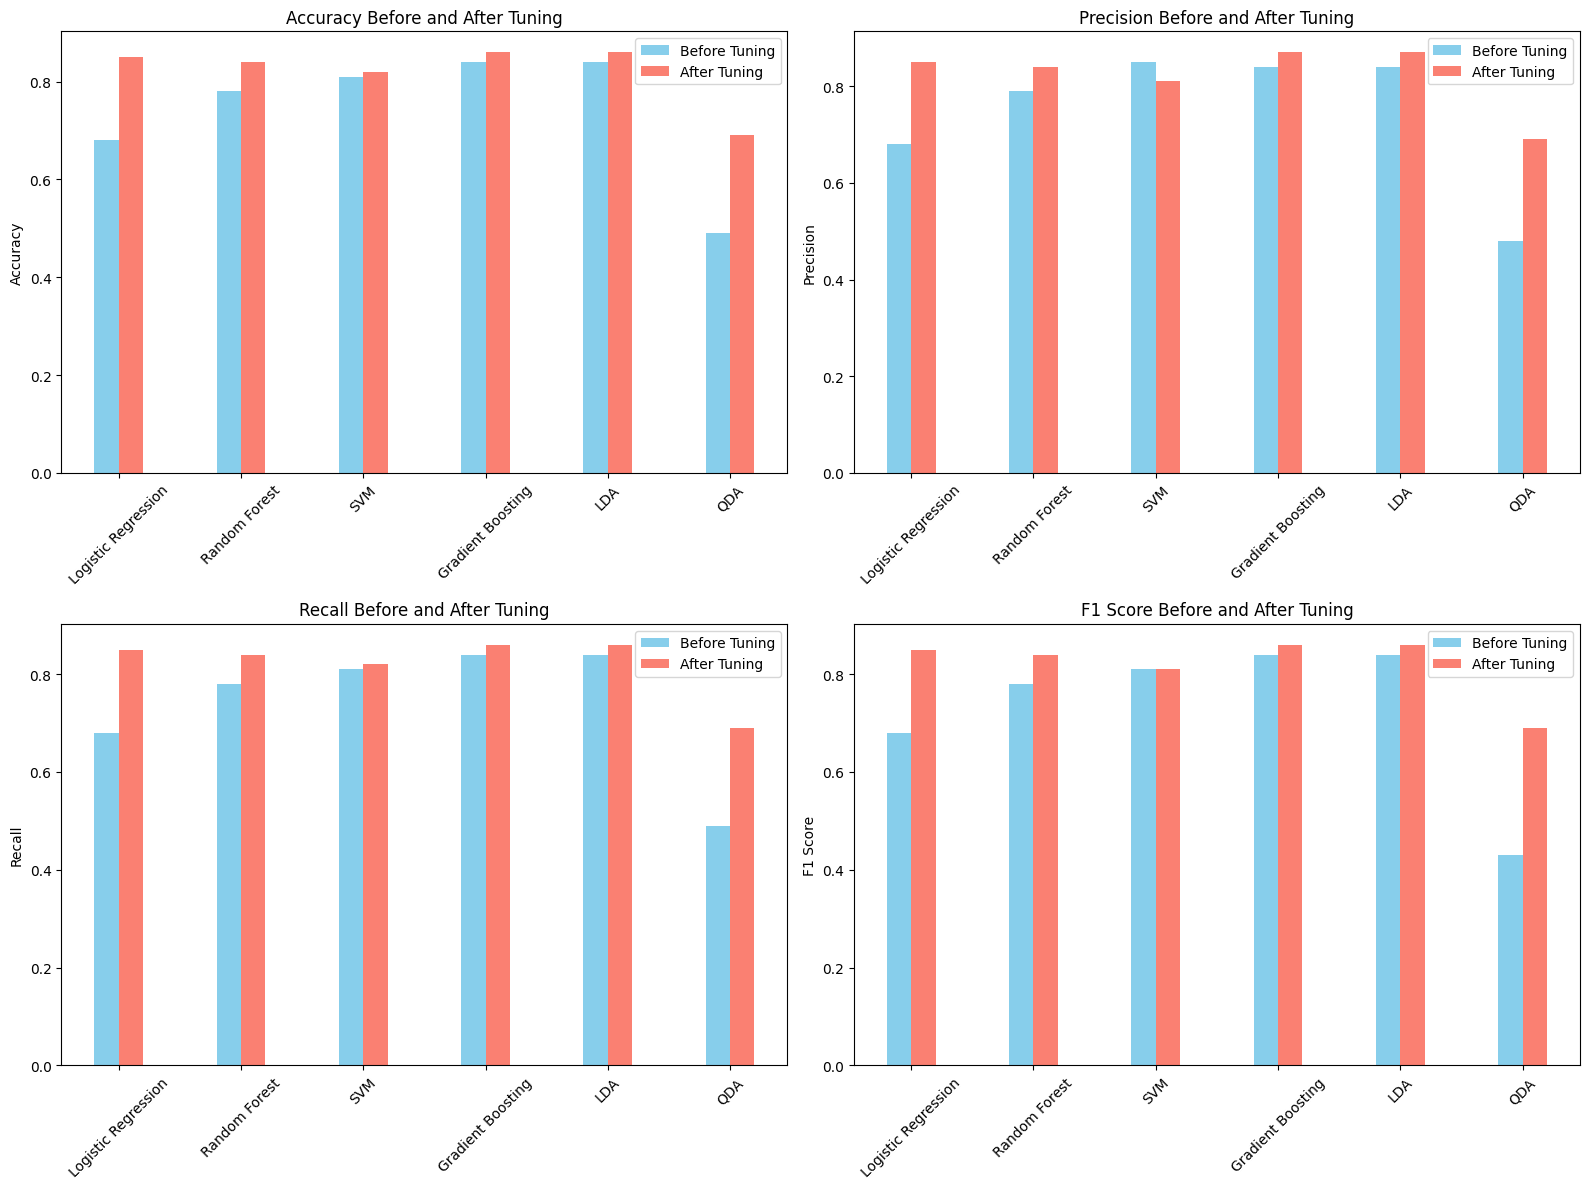

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Logistic Regression', 'Random Forest', 'SVM', 'Gradient Boosting', 'LDA', 'QDA']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
before_tuning = {
    'Accuracy': [0.68, 0.78, 0.81, 0.84, 0.84, 0.49],
    'Precision': [0.68, 0.79, 0.85, 0.84, 0.84, 0.48],
    'Recall': [0.68, 0.78, 0.81, 0.84, 0.84, 0.49],
    'F1 Score': [0.68, 0.78, 0.81, 0.84, 0.84, 0.43]
}
after_tuning = {
    'Accuracy': [0.85, 0.84, 0.82, 0.86, 0.86, 0.69],
    'Precision': [0.85, 0.84, 0.81, 0.87, 0.87, 0.69],
    'Recall': [0.85, 0.84, 0.82, 0.86, 0.86, 0.69],
    'F1 Score': [0.85, 0.84, 0.81, 0.86, 0.86, 0.69]
}

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(2, 2, figsize=(16, 12))

for i, metric in enumerate(metrics):
    row, col = divmod(i, 2)
    ax[row, col].bar(x - width/2, before_tuning[metric], width, label='Before Tuning', color='skyblue')
    ax[row, col].bar(x + width/2, after_tuning[metric], width, label='After Tuning', color='salmon')
    ax[row, col].set_ylabel(metric)
    ax[row, col].set_title(f'{metric} Before and After Tuning')
    ax[row, col].set_xticks(x)
    ax[row, col].set_xticklabels(models, rotation=45)
    ax[row, col].legend()

fig.tight_layout()
plt.show()
